<a href="https://colab.research.google.com/github/SatyaanikaPandam/Data-Science/blob/main/Anika_Unit4Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

In [11]:
#URL link that connects to the raw data within Github
url_2324 = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'
data_2324 = pd.read_csv(url_2324)
# Reading the data and setting 'Pos' (position) column as a categorical variable for group analysis
data = pd.read_csv(url_2324,dtype={'Pos':'category'})
# Keeping only relevant columns: 'Player' (name), 'Pos' (position), 'TRB' (total rebounds)
data = data[['Player','Pos', 'TRB',]]
data


,Player,Pos,TRB
0,Precious Achiuwa,PF-C,487
1,Bam Adebayo,C,737
2,Ochai Agbaji,SG,216
3,Santi Aldama,PF,352
4,Nickeil Alexander-Walker,SG,167
...,...,...,...
567,Thaddeus Young,PF,103
568,Trae Young,PG,149
569,Omer Yurtseven,C,208
570,Cody Zeller,C,112


The data in the violin plot is right skewed aka positive skewness. We see that most of the data will move to the left and there are a few larger values that stretch out to the right. SkewNormal would be a good model to try for this dataset to fit the asymmetry.

In [12]:
# Creating an array of numeric labels for each unique basketball position
pos_idx = data.Pos.cat.codes.values
# Creating an array of the original position labels (e.g., 'G', 'F') for reference
pos_codes = data.Pos.cat.categories
# Organizing position data into a dictionary format for PyMC model compatibility
bask_coords = {"pos": pos_codes}

# The Models

 I also set up the model with a hierarchical structure so that it can pick up any differences across various subgroups present in the data.

<Axes: ylabel='TRB'>

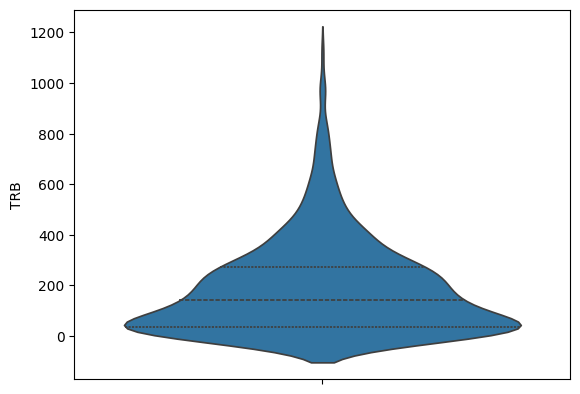

In [13]:
# Visualizing the distribution of total rebounds (TRB) using a violin plot
sns.violinplot(data.TRB,inner='quart')

There were a few divergences. When I checked the fit using a posterior predictive check, it didn’t match up as well as I’d hoped, so an exponential model might be a better fit for the data. Since exponential distributions are often used to model positively skewed data, this distribution might help to align better with the observed skewness and tail behavior in this dataset. An exponential model could reduce the divergence issues.

In [14]:
 with pm.Model(coords = bask_coords) as bask_model:
    # Defining hyperpriors for the mean and standard deviation of rebounds
      # Mean of the mean
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 300)
     # Standard deviation of the mean
    μ_sd = pm.HalfNormal('μ_sd', sigma = 30)
    # Defining priors for mean and standard deviation
    μ = pm.Normal('μ', mu = μ_mu, sigma = μ_sd)
    # Defining a skewness parameter to capture asymmetry in rebound distribution
    σ = pm.HalfNormal('σ', sigma = 10)
    α = pm.Exponential('α', lam = 5)
    # Defining the skew-normal likelihood to model total rebounds
    _ = pm.SkewNormal('trb', mu = μ, sigma = σ, alpha = α, observed = data.TRB.values)

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_bask = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:There were 56 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

<Axes: xlabel='trb'>

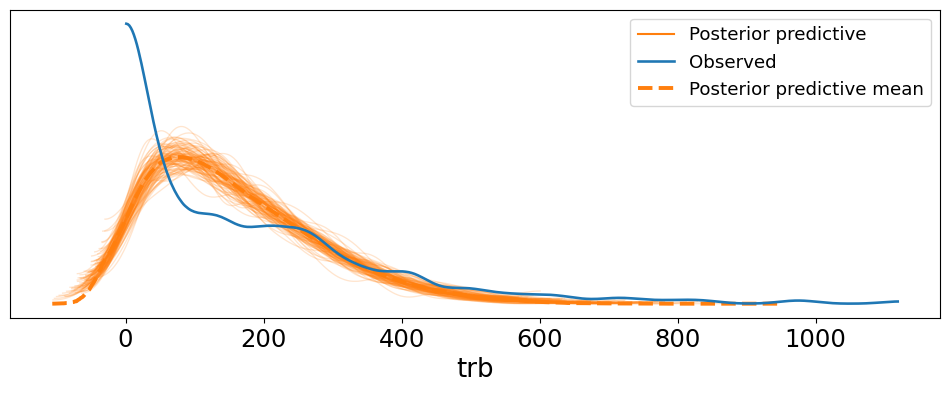

In [9]:
pm.sample_posterior_predictive(idata_bask, model=bask_model, extend_inferencedata=True)
az.plot_ppc(idata_bask, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

After testing both, the SkewNormal model was better because it was able to capture the skewness. The exponeential model was applied without grouping by position, and it performed with zeroo divergences. But itt wans't able to capture the wide data set.

In [15]:
 with pm.Model(coords = bask_coords) as bask_model:
    #hyperpriors
    a = pm.Gamma('a', alpha = 1, beta = 1)
    b = pm.Gamma('b', alpha = 1, beta = 1)
    #priors
    λ = pm.Gamma('λ', alpha = a, beta = b)
    #total rebounds (TRB) with an Exponential distribution
    _ = pm.Exponential('trb', lam = λ, observed = data.TRB.values)

    #Sample from the posterior with higher target_accept to reduce divergences
    idata_bask = pm.sample(target_accept = 0.95)

Output()

Output()

Output()

(0.0, 1100.0)

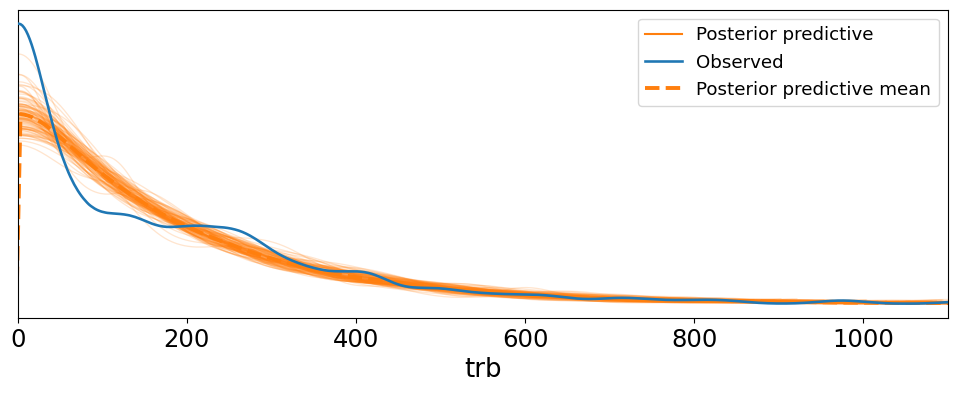

In [16]:
pm.sample_posterior_predictive(idata_bask, model=bask_model, extend_inferencedata=True)
ax = az.plot_ppc(idata_bask, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(0, 1100)

The gamma model is much better because it can account for the skewness and the large data set more than the other 2 models.

In [17]:
with pm.Model(coords = bask_coords) as bask_model:
    #hyperpriors
    a = pm.Gamma('a', alpha = 1, beta = 1)
    b = pm.Gamma('b', alpha = 1, beta = 1)
    #priors
    λ = pm.Gamma('λ', alpha = a, beta = b, dims = "pos")
    #skewnormal
    _ = pm.Exponential('trb', lam = λ[pos_idx], observed = data.TRB.values)
      # Sample from the posterior, increasing target_accept to reduce sampling divergences
    idata_bask = pm.sample(target_accept = 0.95)

Output()

Output()

 I added a grouping by position, allowing eech position to have its own distinct prior distribution while sharing common hyperpaarameters across all groups. Also it ran smoothly without divergences.

In the λ trace plots, you can see that some positions have sharp, clear peaks, which means the parameter estimates are pretty solid with less uncertainty. On the other hand, some positions have wider, flatter distributions, showing that there's more variabiility or less confidence in the estimates for those groups. This diffeerence in the λ patterns across positions tells us that the model might be capturing the data diferently depending on the position, and we’ll see this more clearly in the forest plot

(0.0, 0.015)

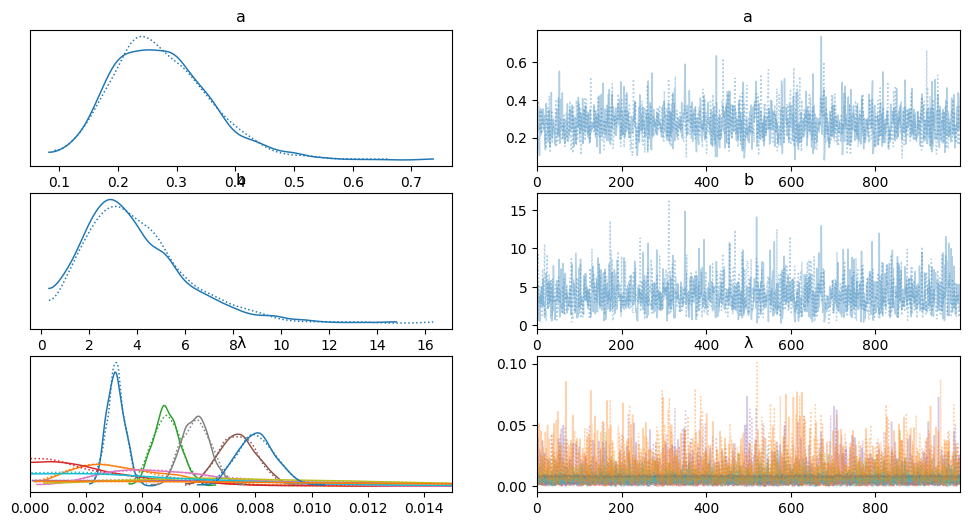

In [18]:
az.plot_trace(idata_bask)[2,0].set_xlim([0, .015])

In [19]:
az.rhat(idata_bask)

<xarray.Dataset> Size: 352B
Dimensions:  (pos: 12)
Coordinates:
  * pos      (pos) <U5 240B 'C' 'C-PF' 'PF' 'PF-C' ... 'SF-SG' 'SG' 'SG-PG'
Data variables:
    a        float64 8B 1.0
    b        float64 8B 1.002
    λ        (pos) float64 96B 1.001 1.0 1.001 1.001 ... 1.0 1.001 0.9994 1.0

array([<Axes: >], dtype=object)

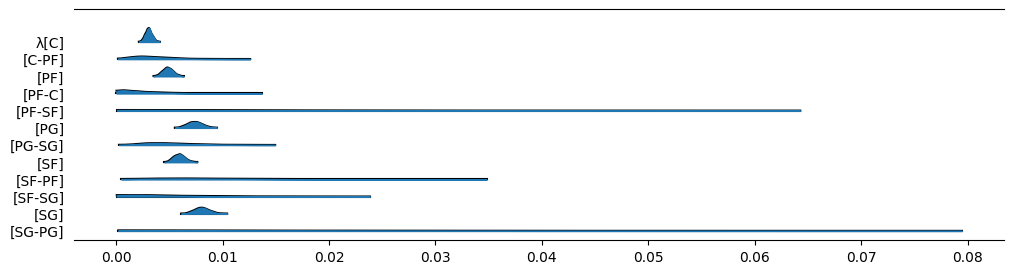

In [20]:
az.plot_forest(idata_bask, var_names=['λ'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

In [21]:
#Retrieve posterior samples for λ
posterior = idata_bask.posterior
lambda_variable = posterior['λ']
# Calculate mean of λ across chains and draws
mean_lambda = lambda_variable.mean(dim=['chain', 'draw'])
mean_array = mean_lambda.values
# Initialize an array for the reciprocals of mean λ values
reciprocal_array = []
for value in mean_array:
   # Calculate reciprocal of each mean λ value and store it
    reciprocal = 1 / value
    reciprocal_array.append(reciprocal)
# Print each position along with its reciprocal λ value
for i in range(len(pos_codes)):
    position = pos_codes[i]
    reciprocal = reciprocal_array[i]
    print(f'{position}: {reciprocal}')

C: 326.90253538191087
C-PF: 290.1348896033814
PF: 205.79871010152726
PF-C: 393.5178716364989
PF-SF: 85.53461891107935
PG: 135.11274959667685
PG-SG: 197.05499770622907
SF: 168.96302126908103
SF-PF: 111.64247282443932
SF-SG: 208.96472770714314
SG: 124.14872157625875
SG-PG: 64.66196999498045


<BarContainer object of 12 artists>

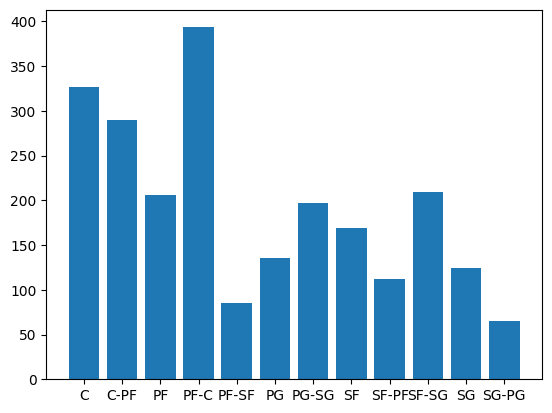

In [22]:
plt.bar(pos_codes, reciprocal_array)

# Conclusion

Let's look at the positions: Center (C), Power Forward (PF), Small Forward (SF), Point Guard (PG), and Shooting Guard (SG). The model's predictions are liniing up pretty well with what we'd expect. In basketball, the Centers and Power Forwards are usully the ones grabbing the most rebounds, since they are usually positioned closer to the basket. That is why we see higher prdicted TRB values for positions like C, C-PF, PF, and PF-C. It also meets the patterns we see in the bar graph. Guards are more about handling the ball and setting up plays, which generally saw fewer rebounds, and that too meets what the model is showing. The model works because the values of TRB for each position align ratger well with the usual roles played.